### House Prices: Advanced Regression Techniques
In this competition we are provided with 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, and we are challenged to predict the final price of each home  

This I believe is one of the best competition for Data Science beginners to learn Regression techniques, EDA, feature engineering and feature selection.  

Without much talk, let's get started!

Contents-
1. [Importing modules and data](#Importing-required-libraries)
2. [Data Exploration and Visualization](#Data-Exploration-and-Visualization)
3. [Feature Engineering](#Feature-Engineering)
4. [Data Modeling](#Data-Modeling)
5. [Predictions](#Predictions)
6. [Final thoughts!](#Final-thoughts!)

**Let's begin!**

#### Importing required libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [2]:
data_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
data_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
# checking if files have been loaded correctly
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data_train.shape, data_test.shape

((1460, 81), (1459, 80))

Training dataset has 1460 records and test has almost equal 1459 records  
There are 80 features in the dataset

### Data Exploration and Visualization

What is min and max SalePrice ?

In [5]:
data_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Maximum price is $755000 which is way higher than the mean and 75th percentile price. I suspect some outliers in the data.  
Let's move on to seeing how many nulls are there in the dataset

In [6]:
# columns which have null values
columns_having_nulls_train = data_train.columns[data_train.isna().any()].sort_values(ascending=False).to_series()

# count of null values in those column
values_train = data_train[columns_having_nulls_train].isna().sum().sort_values(ascending=False)

# percent of null values in those columns
percent_train = (data_train[columns_having_nulls_train].isna().sum()/data_train.shape[0]).sort_values(ascending=False)

# concat series and create a datframe to present the information cleanly
pd.concat([columns_having_nulls_train, values_train, percent_train], axis=1, sort=False, join='inner'
          , keys=['Feature', 'Null Count', 'Percent Null']).sort_values(by=['Null Count'], ascending=False).reset_index(drop=True)

,Feature,Null Count,Percent Null
0,PoolQC,1453,0.995205
1,MiscFeature,1406,0.963014
2,Alley,1369,0.937671
3,Fence,1179,0.807534
4,FireplaceQu,690,0.472603
5,LotFrontage,259,0.177397
6,GarageYrBlt,81,0.055479
7,GarageType,81,0.055479
8,GarageQual,81,0.055479
9,GarageFinish,81,0.055479


Columns - LotFrontage, Alley, FireplaceQu, PoolQC, Fence, MiscFeature have a lot of null values (> 20 %). Let's see what are these columns  

`Alley` - Type of alley access to property - 3 unique values  
`FireplaceQu` - Fireplace quality - 6 unique values  
`PoolQC` - Pool quality - 5 unique values  
`Fence` - Fence quality - 5 unique values  
`MiscFeature` - Miscellaneous feature not covered in other categories - 6 unique values  

We will not use these features in our analysis
  
Let's also check _test_ dataset

In [7]:
columns_having_nulls_test = data_test.columns[data_test.isna().any()].sort_values(ascending=False).to_series()
values_test = data_test[columns_having_nulls_test].isna().sum().sort_values(ascending=False)
percent_test = (data_test[columns_having_nulls_test].isna().sum()/data_test.shape[0]).sort_values(ascending=False)
pd.concat([columns_having_nulls_test, values_test, percent_test], axis=1, sort=False, join='inner'
          , keys=['Feature', 'Null Count', 'Percent Null']).sort_values(by=['Null Count'], ascending=False).reset_index(drop=True)

,Feature,Null Count,Percent Null
0,PoolQC,1456,0.997944
1,MiscFeature,1408,0.965045
2,Alley,1352,0.926662
3,Fence,1169,0.801234
4,FireplaceQu,730,0.500343
5,LotFrontage,227,0.155586
6,GarageQual,78,0.053461
7,GarageCond,78,0.053461
8,GarageFinish,78,0.053461
9,GarageYrBlt,78,0.053461


Again the same _5_ columns have a lot of null value

In [8]:
#data_train.describe().T

We will now visalize the relationship between target variable and features.  
Since there are lot of features in this dataset so from my intution (which we will later see how wrong or correct is) I have ordered features as per their importance. We will start with the ones which I believe people consider as a major factor in deciding price of a house before buying  


How LotArea _(Lot size in square feet)_ is related with Sale Price

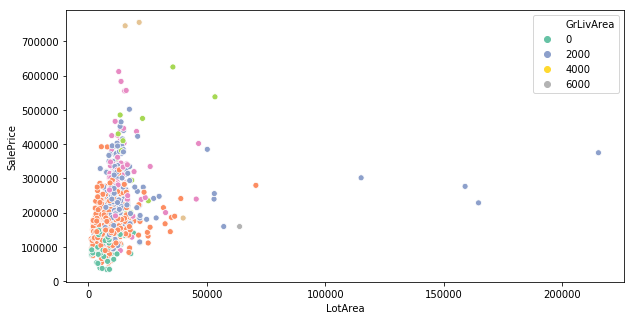

In [9]:
plt.figure(figsize=(10,5))
g = sns.scatterplot(x="LotArea", y="SalePrice", hue="GrLivArea", data=data_train, palette="Set2")

The two right-most points (houses) seems like a outlier in the dataset (as suspected earlier). Their Ground living area (GrLivAre) is between 0-2000 square feet only and are still sold for way higher price.  
Points with very high lot area but less SalePrice seem like an outlier too but they might be Agriculture type (MSZoning) plots and so priced lower. It's just an assumption and could be incorrect.  

We will remove these upon further inspection.

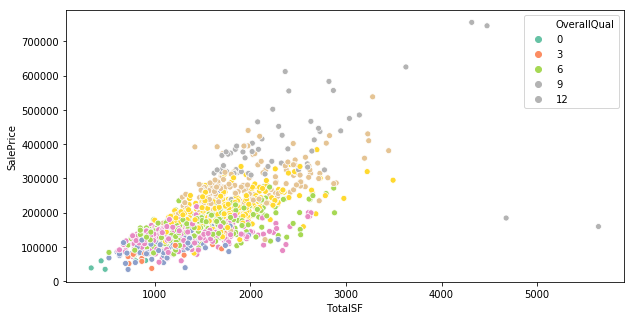

In [10]:
# Let's create a new variable Total Floor Surface Area (1st + 2nd) and see how total surface are is related with SalePrice
data_train['TotalSF'] = data_train['1stFlrSF'] + data_train['2ndFlrSF']
plt.figure(figsize=(10,5))
g = sns.scatterplot(x="TotalSF", y="SalePrice", hue="OverallQual", data=data_train, palette="Set2")

Those two houses with highest prices seem to follow the trend and do not seem like a complete outlier anymore. We will keep them in our dataset.  
    Althouh we can see points with a lot high Surface area but lesser Sale Price. **Are they outliers?**

Now, Let's check how Sale Price varies with `TotRmsAbvGrd` - Total rooms above grade

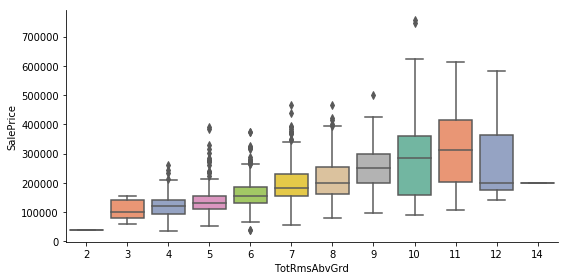

In [11]:
g = sns.catplot(x="TotRmsAbvGrd", y="SalePrice", kind="box", data=data_train, aspect=2, height=4, palette="Set2")

**Observation -** Generally, Sale Price seems to be increasing as Total Rooms in House increases but no linear or constantly increasing relationship

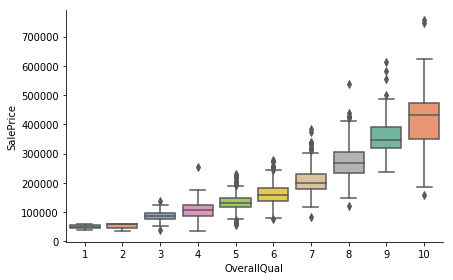

In [12]:
g = sns.catplot(x="OverallQual", y="SalePrice", kind="box", data=data_train, aspect=1.6, height=4, palette="Set2")

SalePrice directly (non-linearly) proportional to Overall Quality of House

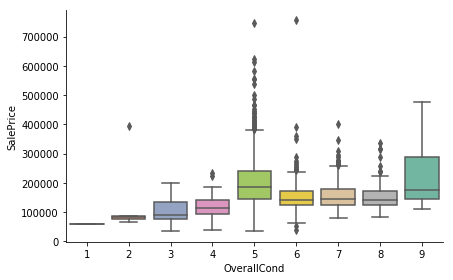

In [13]:
g = sns.catplot(x="OverallCond", y="SalePrice", kind="box", data=data_train, aspect=1.6, height=4, palette="Set2")

Does number of baths affect the SalePrice?

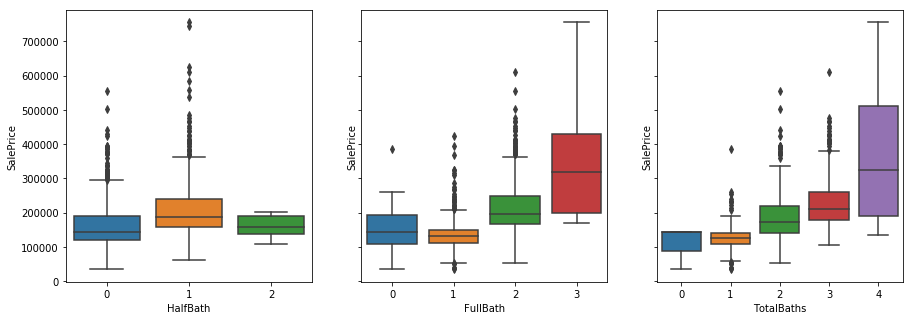

In [14]:
data_train['TotalBaths'] = data_train['FullBath'] + data_train['HalfBath']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (15, 5))
sns.boxplot(x="HalfBath", y="SalePrice", data=data_train, ax=ax1)
sns.boxplot(x="FullBath", y="SalePrice", data=data_train, ax=ax2)
sns.boxplot(x="TotalBaths", y="SalePrice", data=data_train, ax=ax3)

Varies as the number of baths increase. Interesting to see that there are houses with 0 Baths too!

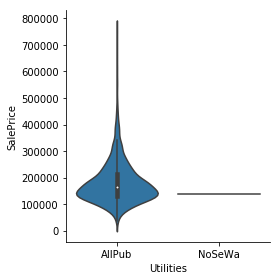

In [15]:
sns.catplot(x="Utilities", y="SalePrice", kind="violin", data=data_train, aspect=1, height=4)

Interesting, there are only two types of utilities present in training dataset when there could be 4 possible values (as per data description sheet). Also the houses with _NoSeWa_ (Electricity and Gas Only) utility seem to be extremely less.  
Let's see how many houses are there with _NoSeWa_ utility  
and  
How many types of Utilities are present in test dataset

In [16]:
data_train[data_train['Utilities']=='NoSeWa'].shape[0]

1

Only 1 record with 'NoSeWa' utility

In [17]:
data_test['Utilities'].value_counts()

AllPub    1457
Name: Utilities, dtype: int64

data_test also seems to have only one value for utility, we are fine!  
  
This also tells us that `Utilities` feature is not at all important (in our dataset) in determining Sale Price of house

Now, Let's see how the average selling price varies with year they got built in

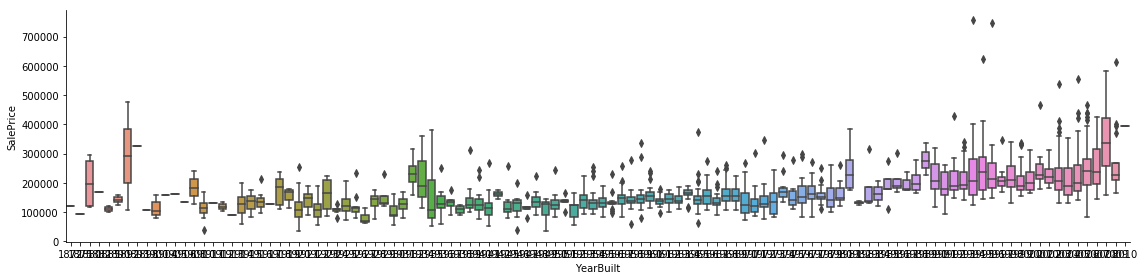

In [18]:
g = sns.catplot(x="YearBuilt", y="SalePrice", kind="box", data=data_train, aspect=4, height=4)

There is no clear trend but the median selling price of newer houses is _generally_ higher than older ones

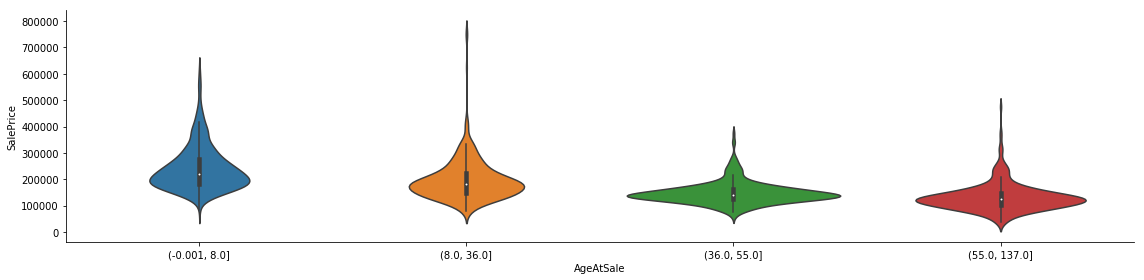

In [19]:
# Age before selling
data_train['AgeAtSale'] = data_train['YrSold'] - data_train['YearBuilt'] + data_train['MoSold']/12
data_train['AgeAtSale'] = round(data_train['AgeAtSale'])
data_train['AgeAtSale'] = pd.qcut(data_train['AgeAtSale'], 4)
g = sns.catplot(x="AgeAtSale", y="SalePrice", kind="violin", data=data_train, aspect=4, height=4)

As expected, Sale Price of older houses is less then newer

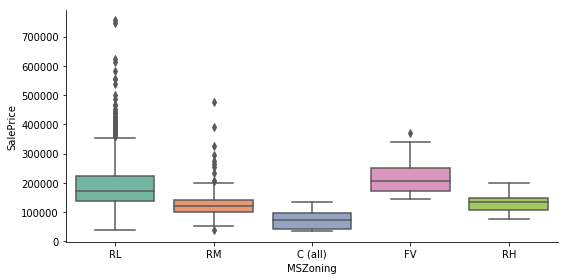

In [20]:
sns.catplot(x="MSZoning", y="SalePrice", kind="box", data=data_train, aspect=2, height=4, palette="Set2")

MSZoning - zoning classification (Agriculture, Commercial, Industrial, Residential) - seem to influence the house prices.  
FV (Floating Village Residential) were sold for higher median price as compard to others. (May be they were bigger house?)  

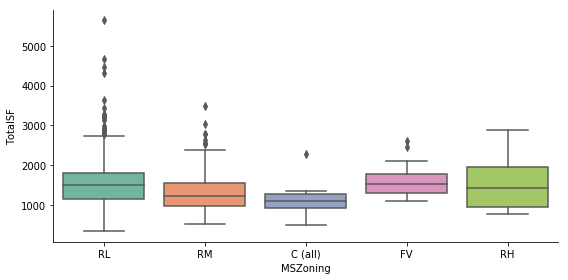

In [21]:
sns.catplot(x="MSZoning", y="TotalSF", kind="box", data=data_train, aspect=2, height=4, palette="Set2")

So the `Total Surface Area` vs `MSZoning` plot looks similar to `SalePrice` vs `MSZoning` plot.  
Median TotalSF in FV Zone is higher compared to others which explains higher sale prices of houses in that area.

Out of curiosity, how many MSZoning categories are there in test dataset?

In [22]:
data_test['MSZoning'].unique()

array(['RH', 'RL', 'RM', 'FV', 'C (all)', nan], dtype=object)

Test dataset has the same categories which are present in training

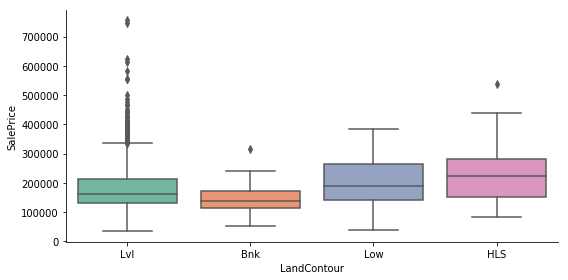

In [23]:
sns.catplot(x="LandContour", y="SalePrice", kind="box", data=data_train, aspect=2, height=4, palette="Set2")

HLS - Hillside - houses seemed to be priced bit higher, there is no high correlation though

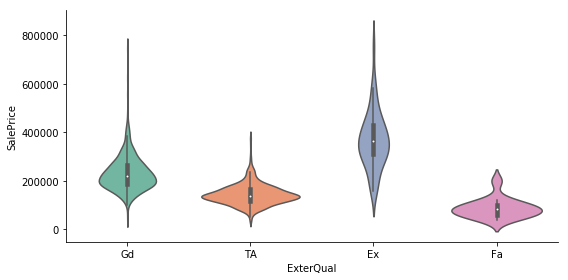

In [24]:
sns.catplot(x="ExterQual", y="SalePrice", kind="violin", data=data_train, aspect=2, height=4, palette="Set2")

Exterial Quality vs Sale Price  
`Gd` -> Good  
`TA` -> Average/Typical  
`Ex` -> Excellent  
`Fa` -> Fair  
This expected and Self explanatory

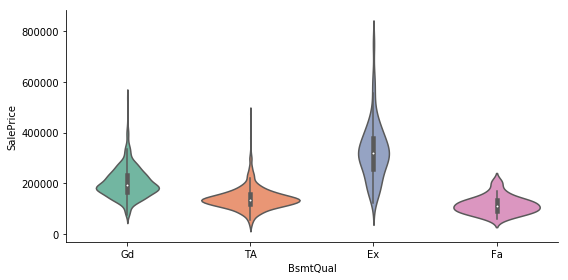

In [25]:
sns.catplot(x="BsmtQual", y="SalePrice", kind="violin", data=data_train, aspect=2, height=4, palette="Set2")

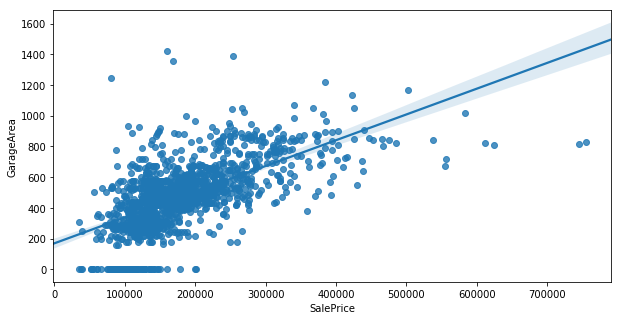

In [26]:
plt.figure(figsize=(10,5))
g = sns.regplot(x="SalePrice", y="GarageArea", data=data_train)

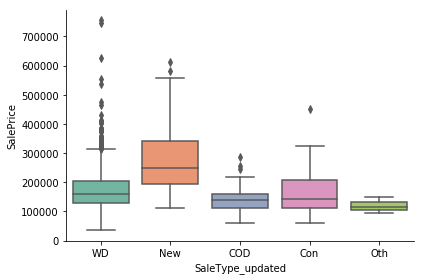

In [27]:
data_train['SaleType_updated'] = data_train['SaleType']
data_train.loc[((data_train['SaleType'] == 'WD') | (data_train['SaleType'] == 'CWD') | (data_train['SaleType'] == 'VWD')), 'SaleType_updated'] = 'WD'
data_train.loc[((data_train['SaleType'] == 'Con') | (data_train['SaleType'] == 'ConLD') | (data_train['SaleType'] == 'ConLI') | (data_train['SaleType'] == 'ConLw')), 'SaleType_updated'] = 'Con'
sns.catplot(x="SaleType_updated", y="SalePrice", kind="box", data=data_train, aspect=1.5, height=4, palette="Set2")

Hmm.. what if we club categories further?

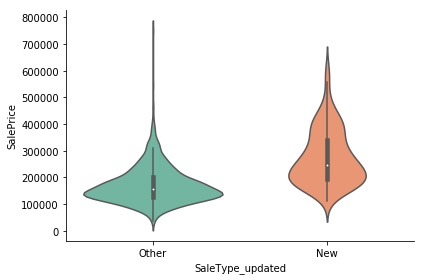

In [28]:
data_train.loc[(data_train['SaleType'] != 'New'), 'SaleType_updated'] = 'Other'
sns.catplot(x="SaleType_updated", y="SalePrice", kind="violin", data=data_train, aspect=1.5, height=4, palette="Set2")

So we can see the relation quite clear now. Newer houses are priced higher as compared to old.

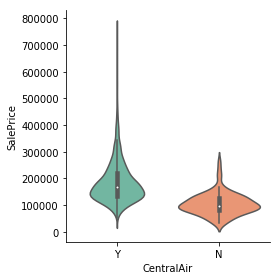

In [29]:
sns.catplot(x="CentralAir", y="SalePrice", kind="violin", data=data_train, aspect=1, height=4, palette="Set2")

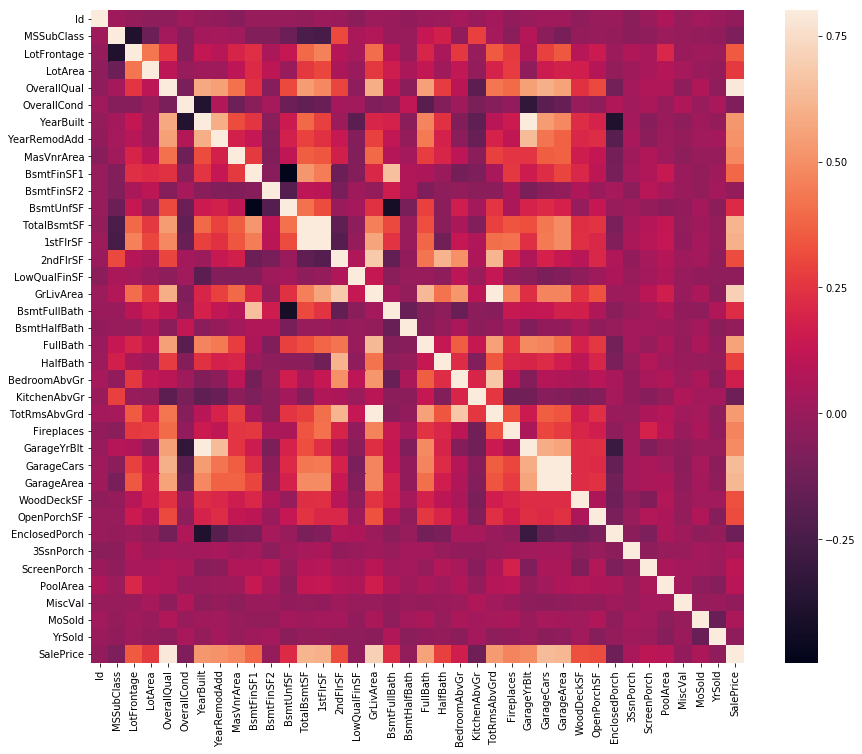

In [30]:
corrmat = data_train.loc[:,~data_train.columns.isin(['TotalSF','TotalBaths'])].corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

Features having Medium to High Correlation with SalePrice which we missed -  
`TotalBsmtSF` (highly correlated with 1stFlrSF), `FullBath`, `GarageCars` (highly co-realted with GarageArea)  

Correlated features -  
* GarageYrBuilt with YearBuilt - We will keep YearBuilt as GarageYrBuilt has some null values
* 1stFlrSF with TotalBsmtSF
* TotalRmsAbvGrd with GrLivArea
* TotalRmsAbvGrd with BedroomAbvGr but BedroomAbvGr is not correlated with SalePrice so we will not use this feature
We will which feature's correlation is higher with SalePrice and then remove other correlated feature

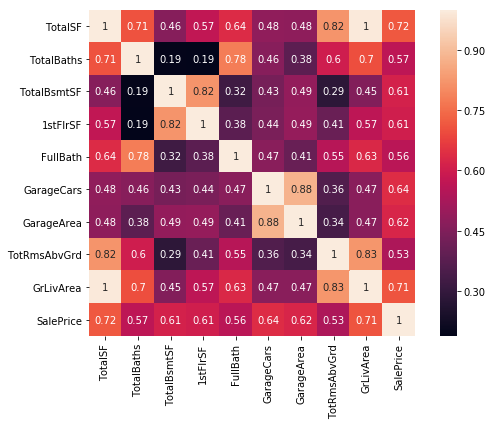

In [31]:
corrmat = data_train[['TotalSF','TotalBaths','TotalBsmtSF','1stFlrSF','FullBath','GarageCars','GarageArea','TotRmsAbvGrd','GrLivArea','SalePrice']].corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, square=True, annot=True);

We can see that 'YearBuilt', 'GrLivArea', 'GarageCars' have higher correlation with SalePrice as compared to 'GarageYrBlt', 'TotRmsAbvGrd', 'GarageArea' respectively so we will keep 'YearBuilt', 'GrLivArea', 'GarageCars' features.  
1stFlrSF with TotalBsmtSF are equally correlated with SalePrice so we can keep any one of them. I'll keep 1stFlrSF

**Oservations:-**  

From separate visuals-
* SalePrice increases exponentially with increase in LotArea
* SalePrice seems to be increasing linearly with TotalSF (1stFlrSF + 2ndFlrSF), though the variance in as SF increases
* As Total rooms above ground increases, median Sale Price increases. Not quite true when rooms = 12 though
* SalePrice increases exponentially as Overall Quality of house increases but the relation is not so strong with Overall Condition (OverallCond) of house
* We do not have enough data to see relationship with Utility
* Price of newer houses (YearBuilt) tend to be more than old. We can see this relationship using SaleType variable too.
* Houses having central air conditioning are priced higher  

From HeatMap-  
* LotFrontage has ~17% null values and isn't highly correlated (correlation - 0.35) with SalePrice so we will remove it
* _OverallCond, BsmtFinSF2, BsmtUnfSF, LowQualFinSF, BsmtFullBath, BsmtHalfBath, HalfBath, BedroomAbvGrd, KitchenAbvGrd, WoodDeckSF, OpenPorchSF, EncliosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal_ are not significantly correlated with SalePrice and hence we would not include them in modeling
* We will not keep 'TotalSF' as it is exactly same as GrLivArea (Huh! didn't knew that before)
* We will keep GrLivArea and remove '2ndFlrSF' to avoid _collinearity_
* We will keep feature 'TotalBaths' as it is also quite correlated to SalePrice
* MSSubclass is actually categorical variable but because it has numeric values it appeared in Heatmap
* OverallCond is a categorical variable too but in our case we would be just fine if we treat it as numeric too
* MoSold, YrSold are significantly correlated too and we don't expect MoSold (Month in which house was sold) to be correlated with SalePrice either. We will create a Age feature first and then can get rid of these.
* We are yet to see correlation with some of the categorical features which we missed before and not included on HeatMap

So to summarize - we will keep only these numerical columns in our regression model  

___'1stFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'EnclosedPorch', 'Fireplaces', 'FullBath','TotalBaths, 'GarageCars', 'GrLivArea', 'KitchenAbvGr', 'LotArea', 'MasVnrArea', 'SalePrice', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold'___  

To note- we will remove MoSold and YrSold feature after we create House Age feature. We will create an additional categorical feature from _2ndFlrSF_ variable - if it is zero then single story house else double story house  
We will create a House Age before sold After remodeling from YearRemodAdd and then remove YearRemodAdd variable  

We will gently move towards Feature Engineering now and we will explore, update, eliminate some of the categorical features

### Feature Engineering

Let's first note down the columns we will remove before regression modeling (this is by using the knowledge we gained from data visualization we did just a while ago)

In [32]:
cols_to_remove1 = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage']  #cols with lot of nulls
cols_to_remove2 = ['GarageYrBlt', 'TotRmsAbvGrd', 'GarageArea', 'TotalBsmtSF'] #correlated with other feature
cols_to_remove3 = ['Utilities'] #not contributing to prediction
cols_to_remove4 = ['OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 
                   'HalfBath', 'BedroomAbvGrd', 'KitchenAbvGrd', 'WoodDeckSF', 'OpenPorchSF', 'EncliosedPorch', '3SsnPorch', 
                   'ScreenPorch', 'PoolArea', 'MiscVal']
# 'MSSubclass', 'MoSold', 'YrSold' -- on hold

We will now encode convert categorical variable and check their correlation with SalePrice

In [33]:
# from our understanding of data
categorical_cols = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope',
                   'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle',
                   'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual',
                    'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical',
                   'KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
                   'PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition',
                    'MoSold']

In [34]:
# so what remains are the numerical columns
numerical_cols = list(set(data_train.columns.tolist()) - set(categorical_cols))

Now, we need to find out useful categorical columns from below  

_BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSSubClass, MSZoning, MasVnrType, MoSold, Neighborhood, OverallQual, PavedDrive, RoofMatl, RoofStyle, SaleCondition, Street_

From our visualization exercise we already know that-  
OverallQual, MSZoning, ExterQual, BsmtQual, CentralAir contribute towards determining SalePrice but OverallCond, Utilities, LandContour, SaleType do not  

We will not consider __Neighborhood__ as it has a lot of catergories (you can try grouping values or use embedding if you don't want to remove this variable - I'll leave this up to you!)  
On a side note, I found this answer helpful if in future you are working on a problem and you are required to collapse some of the categorical variables having many levels (_fusion of categories_ is what it's called btw) - https://stats.stackexchange.com/a/237000  

___*Before we move forward,___ Some of the points I have written below may not come obvious to you and you might wonder how I reached to that (deletion/grouping) conclusion so I should clarify that I had separately visualized all those variables with SalePrice and then arrived at the conclusion whether to remove them from analysis, keep them as it is or keep them but group the categories. This was done to keep this notebook short. If you don't find some of them intutive, please go ahead fork the notebook and analyse them yourself and if you find something wrong with my analysis/conclusions then please mention it in the comments :)

We will remove following variables as they do not help with prediction  
* BldgType
* We will remove Condition1 and Condition2 because the frequency of categories other than 'Normal' is very low and so this variable would like have an insignificant affect on SalePrice
* ExterCond - we already have ExterQual which seem to be more correlated with sale price
* Exterior1st and Exterior2nd
* Foundation, Functional (frequency of some categories very low), LotConfig, LandSlope, LotShape, MasVnrType, MoSold, PavedDrive, RoofMatl (frequency of categories other than 'CompShg' is very low), RoofStyle, Street (frequency of 'Gravel' category is too low)

Following variables are related, we will either remove some of them, group them or create new features from them-  
* BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 - We will keep only __BsmtCond__
* Remove GarageCond, GarageFinish - Keep __GarageQual__, __GarageType__
* Remove HeatingQC and Keep __Heating__
* Remove MSSubClass as it looks related to HouseStyle, keep __HouseStyle__
* Remove SaleCondition as it is correlated with SaleType, keep __SaleType__ (we can keep any of these, I just tend to like SaleType more)


Finally, we will level down (grouping/fuse categories) these categorical variables-  
* ___Electrical___ - group categories other than SBrkr (Standard Circuit Breakers & Romex) into one category
* ___KitchenQual___ -  group 'Fa' and 'TA' category into only 1 ('Fa')
* ___SaleType___ - in New (New) and Old (all other categories) house
* ___GarageQual___ - Group into 'Good' (Ex, TA, Gd) and 'Poor' (Fa, Po)
* ___GarageType___ - Group in Attached (Attchd, BuiltIn, Basment, 2Types) and Detached (Detchd, CarPort, )
* ___Heating___ - Group - Gas (GasA, GasW) and Not-Gas (Floor, Wall, Grav, OthW)
* ___HouseStyle___ - Group in 'Finished' (except 1.5Unf, 2.5Unf) and 'Unfinished' (1.5Unf, 2.5Unf)

**To Summarize, we will remove below variables**  
OverallCond, Utilities, LandContour, SaleCondition, Neighborhood, BldgType, Condition1, Condition2, ExterCond, Exterior1st, Exterior2nd, Foundation, Functional, LotConfig, LandSlope, LotShape, MasVnrType, MoSold, PavedDrive, RoofMatl, RoofStyle, Street, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageCond, GarageFinish, HeatingQC, MSSubClass

**And now we are only left with these categorical variables-**  
_'BsmtQual', 'CentralAir', 'Electrical', 'ExterQual', 'GarageQual', 'GarageType', 'Heating', 'HouseStyle', 'KitchenQual', 'MSZoning', 'OverallQual', 'SaleType'_  

Phew! This was a very lengthy and time consuming exercise 

**Ok, let's move the next steps. We will now do the following**
- Remove Outliers
- Fill NA values
- Create new features
- Delete features which are not required for analysis
- Fuse categories in some categorical features
- Do OneHotEncoding for Categorical Features
- Standardize Numerical Features

**Remove Outliers**  
As we saw in TotalSF vs SalePrice data that two houses have a very high Surface area but are priced quite low. We will remove points from our dataset

In [35]:
data_train = data_train[~((data_train['TotalSF'] > 4000) & (data_train['SalePrice'] < 300000))]

let's check the shape of data_train to confirm that they are removed

In [36]:
data_train.shape

(1458, 85)

**Let's fill the NA values**

Columns having nulls in training dataset - ['GarageType', 'MasVnrArea', 'BsmtQual', 'Electrical', 'GarageQual']  
Columns having nulls in test dataset - ['KitchenQual', 'GarageType', 'MSZoning', 'MasVnrArea', 'BsmtQual', 'SaleType', 'BsmtFinSF1', 'GarageCars', 'GarageQual']

We will fill NA values in categorical columns with `Mode` and Numerical columns with `Mean` (You can try `Median` too)

In [37]:
data_train['GarageType'].fillna(value=data_train['GarageType'].mode()[0], inplace=True)
data_train['BsmtQual'].fillna(value=data_train['BsmtQual'].mode()[0], inplace=True)
data_train['Electrical'].fillna(value=data_train['Electrical'].mode()[0], inplace=True)
data_train['GarageQual'].fillna(value=data_train['GarageQual'].mode()[0], inplace=True)
data_train['MasVnrArea'].fillna(value=data_train['MasVnrArea'].mean(), inplace=True)

In [38]:
data_test['KitchenQual'].fillna(data_test['KitchenQual'].mode()[0], inplace=True)
data_test['GarageType'].fillna(data_test['GarageType'].mode()[0], inplace=True)
data_test['MSZoning'].fillna(data_test['MSZoning'].mode()[0], inplace=True)
data_test['BsmtQual'].fillna(data_test['BsmtQual'].mode()[0], inplace=True)
data_test['SaleType'].fillna(data_test['SaleType'].mode()[0], inplace=True)
data_test['GarageCars'].fillna(data_test['GarageCars'].mode()[0], inplace=True)
data_test['GarageQual'].fillna(data_test['GarageQual'].mode()[0], inplace=True)
data_test['MasVnrArea'].fillna(data_test['MasVnrArea'].mean(), inplace=True)
data_test['BsmtFinSF1'].fillna(data_test['BsmtFinSF1'].mean(), inplace=True)

In [39]:
data_train[['GarageType', 'MasVnrArea', 'BsmtQual', 'Electrical', 'GarageQual']].isna().any().sum()

0

In [40]:
data_test[['KitchenQual', 'GarageType', 'MSZoning', 'MasVnrArea', 'BsmtQual', 'SaleType', 'BsmtFinSF1', 'GarageCars', 'GarageQual']].isna().any().sum()

0

All NA values in train and test datasets are filled now

**Creating new features**

In [41]:
# data_train['AgeAtSale'] - Already created
data_train['RemodAgeAtSale'] = data_train['YrSold'] - data_train['YearRemodAdd']
data_train['RemodAgeAtSale'] = round(data_train['RemodAgeAtSale'])
data_train['RemodAgeAtSale'] = pd.cut(data_train['RemodAgeAtSale'], 3)

In [42]:
data_train['IsMultiStory'] = data_train['2ndFlrSF'].apply(lambda x: 0 if x <= 0 else 1)

Remember, we will need to do the same for test dataset too

In [43]:
data_test['AgeAtSale'] = data_test['YrSold'] - data_test['YearBuilt'] + data_test['MoSold']/12
data_test['AgeAtSale'] = round(data_test['AgeAtSale'])
data_test['AgeAtSale'] = pd.qcut(data_test['AgeAtSale'], 4)

data_test['TotalBaths'] = data_test['FullBath'] + data_test['HalfBath']

data_test['RemodAgeAtSale'] = data_test['YrSold'] - data_test['YearRemodAdd']
data_test['RemodAgeAtSale'] = round(data_test['RemodAgeAtSale'])
data_test['RemodAgeAtSale'] = pd.cut(data_test['RemodAgeAtSale'], 3)

data_test['IsMultiStory'] = data_test['2ndFlrSF'].apply(lambda x: 0 if x <= 0 else 1)

**Deleting features which are not required**

In [44]:
# 'Id' is kept so that we can create submission files at the end
num_cols_to_keep = ['Id','1stFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'EnclosedPorch', 'Fireplaces', 'TotalBaths', 'FullBath', 'GarageCars', 'GrLivArea', 'KitchenAbvGr', 'LotArea', 'MasVnrArea', 'SalePrice']
cat_cols_to_keep = ['BsmtQual', 'CentralAir', 'Electrical', 'ExterQual', 'GarageQual', 'GarageType', 'Heating', 'HouseStyle', 'KitchenQual', 'MSZoning', 'OverallQual', 'SaleType']
new_cols_we_created = ['IsMultiStory','AgeAtSale','RemodAgeAtSale']
cols_to_keep = list(set(num_cols_to_keep)|set(cat_cols_to_keep)|set(new_cols_we_created))

In [45]:
data_train = data_train[cols_to_keep]
data_train.shape

(1458, 29)

In [46]:
data_test = data_test[list(set(cols_to_keep) - {'SalePrice'})]
data_test.shape

(1459, 28)

**Fuse Categories**

In [47]:
data_train.loc[(data_train['Electrical'] != 'SBrkr'), 'Electrical'] = 0
data_train.loc[(data_train['Electrical'] == 'SBrkr'), 'Electrical'] = 1

data_train.loc[((data_train['KitchenQual'] == 'Fa') | (data_train['KitchenQual'] == 'TA')), 'KitchenQual'] = 'Fa'

data_train.loc[(data_train['SaleType'] != 'New'), 'SaleType'] = 0
data_train.loc[(data_train['SaleType'] == 'New'), 'SaleType'] = 1

data_train.loc[((data_train['GarageQual'] == 'Fa') | (data_train['GarageQual'] == 'Po')), 'GarageQual'] = 0
data_train.loc[(data_train['GarageQual'] != 'Poor'), 'GarageQual'] = 1

data_train.loc[((data_train['GarageType'] == 'Attchd') | (data_train['GarageType'] == 'BuiltIn') | (data_train['GarageType'] == 'Basment') | (data_train['GarageType'] == '2Types') ), 'GarageType'] = 1
data_train.loc[((data_train['GarageType'] == 'Detchd') | (data_train['GarageType'] == 'CarPort') ), 'GarageType'] = 0

data_train.loc[((data_train['Heating'] == 'Floor') | (data_train['Heating'] == 'Wall') | (data_train['Heating'] == 'Grav') | (data_train['Heating'] == 'OthW') ), 'Heating'] = 0
data_train.loc[((data_train['Heating'] == 'GasA') | (data_train['Heating'] == 'GasW') ), 'Heating'] = 1

data_train.loc[((data_train['HouseStyle'] == '1.5Unf') | (data_train['HouseStyle'] == '2.5Unf') ), 'HouseStyle'] = 0
data_train.loc[(data_train['HouseStyle'] != 'Unfinished'), 'HouseStyle'] = 1

In [48]:
data_test.loc[(data_test['Electrical'] != 'SBrkr'), 'Electrical'] = 0
data_test.loc[(data_test['Electrical'] == 'SBrkr'), 'Electrical'] = 1

data_test.loc[((data_test['KitchenQual'] == 'Fa') | (data_test['KitchenQual'] == 'TA')), 'KitchenQual'] = 'Fa'

data_test.loc[(data_test['SaleType'] != 'New'), 'SaleType'] = 0
data_test.loc[(data_test['SaleType'] == 'New'), 'SaleType'] = 1

data_test.loc[((data_test['GarageQual'] == 'Fa') | (data_test['GarageQual'] == 'Po')), 'GarageQual'] = 0
data_test.loc[(data_test['GarageQual'] != 'Poor'), 'GarageQual'] = 1

data_test.loc[((data_test['GarageType'] == 'Attchd') | (data_test['GarageType'] == 'BuiltIn') | (data_test['GarageType'] == 'Basment') | (data_test['GarageType'] == '2Types') ), 'GarageType'] = 1
data_test.loc[((data_test['GarageType'] == 'Detchd') | (data_test['GarageType'] == 'CarPort') ), 'GarageType'] = 0

data_test.loc[((data_test['Heating'] == 'Floor') | (data_test['Heating'] == 'Wall') | (data_test['Heating'] == 'Grav') | (data_test['Heating'] == 'OthW') ), 'Heating'] = 0
data_test.loc[((data_test['Heating'] == 'GasA') | (data_test['Heating'] == 'GasW') ), 'Heating'] = 1

data_test.loc[((data_test['HouseStyle'] == '1.5Unf') | (data_test['HouseStyle'] == '2.5Unf') ), 'HouseStyle'] = 0
data_test.loc[(data_test['HouseStyle'] != 'Unfinished'), 'HouseStyle'] = 1

**Label/One Hot Encoding**

Now we need to one hot encode or label encode some of the categorical variable (why just some and not all? We converted some of them 0 and 1 already while _fusing_ categories)  

We only need to convert these categorical variables - _BsmtQual, CentralAir, ExterQual, KitchenQual, MSZoning, OverallQual, AgeAtSale, RemodAgeAtSale_

We will leave _OverallQual_ as it is, One Hot encode _MSZoning, AgeAtSale and RemodAgeAtSale_ and Label encode remaining variables  

In [49]:
data_train['BsmtQual'].replace({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, inplace=True)
data_train['ExterQual'].replace({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, inplace=True)
data_train['KitchenQual'].replace({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, inplace=True)
data_train['CentralAir'].replace({'Y': 1, 'N': 2}, inplace=True)
#---
data_test['BsmtQual'].replace({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, inplace=True)
data_test['ExterQual'].replace({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, inplace=True)
data_test['KitchenQual'].replace({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, inplace=True)
data_test['CentralAir'].replace({'Y': 1, 'N': 2}, inplace=True)

In [50]:
data_train = pd.get_dummies(data_train, columns=['MSZoning','AgeAtSale','RemodAgeAtSale'])
data_test = pd.get_dummies(data_test, columns=['MSZoning','AgeAtSale','RemodAgeAtSale'])

In [51]:
data_train.columns

Index(['BsmtQual', 'GarageType', 'GarageQual', 'FullBath', 'HouseStyle',
       'CentralAir', 'GrLivArea', 'TotalBaths', 'KitchenAbvGr', 'OverallQual',
       'Heating', 'BsmtFinSF1', 'ExterQual', 'SalePrice', '1stFlrSF',
       'EnclosedPorch', 'GarageCars', 'Fireplaces', 'KitchenQual', 'SaleType',
       'LotArea', 'IsMultiStory', 'Electrical', 'BedroomAbvGr', 'Id',
       'MasVnrArea', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'AgeAtSale_(-0.001, 8.0]',
       'AgeAtSale_(8.0, 36.0]', 'AgeAtSale_(36.0, 55.0]',
       'AgeAtSale_(55.0, 137.0]', 'RemodAgeAtSale_(-0.06, 20.0]',
       'RemodAgeAtSale_(20.0, 40.0]', 'RemodAgeAtSale_(40.0, 60.0]'],
      dtype='object')

**Standardizing Numerical Features**

In [52]:
data_train[num_cols_to_keep].describe()

,Id,1stFlrSF,BedroomAbvGr,BsmtFinSF1,EnclosedPorch,Fireplaces,TotalBaths,FullBath,GarageCars,GrLivArea,KitchenAbvGr,LotArea,MasVnrArea,SalePrice
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,730.251715,1158.851166,2.866255,438.827160,21.984225,0.611111,1.945816,1.563786,1.766118,1510.465706,1.046639,10459.936900,102.753793,180932.919067
std,421.601532,372.039498,0.816323,432.969094,61.155666,0.641988,0.793210,0.549891,0.747104,507.878508,0.220483,9859.198156,178.948843,79495.055285
min,1.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,1300.000000,0.000000,34900.000000
25%,365.250000,882.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1128.500000,1.000000,7544.500000,0.000000,129925.000000
50%,730.500000,1086.000000,3.000000,382.000000,0.000000,1.000000,2.000000,2.000000,2.000000,1461.500000,1.000000,9475.000000,0.000000,163000.000000
75%,1094.750000,1390.750000,3.000000,711.000000,0.000000,1.000000,3.000000,2.000000,2.000000,1776.000000,1.000000,11600.000000,163.750000,214000.000000
max,1460.000000,3228.000000,8.000000,2188.000000,552.000000,3.000000,4.000000,3.000000,4.000000,4476.000000,3.000000,215245.000000,1600.000000,755000.000000


We will Standardize only columns which have too min/max values quite high when compared to others. We won't standardize columns having max values = 1,2, .. 5 etc.

In [53]:
cols_to_standardize = ['1stFlrSF', 'BsmtFinSF1', 'EnclosedPorch', 'GrLivArea', 'LotArea', 'MasVnrArea']
col_scalar = MinMaxScaler()
for col in cols_to_standardize:
    data_train[col] = col_scalar.fit_transform(data_train[col].values.reshape(-1,1))
    data_test[col] = col_scalar.transform(data_test[col].values.reshape(-1,1))

In [54]:
data_train[cols_to_standardize].head()

,1stFlrSF,BsmtFinSF1,EnclosedPorch,GrLivArea,LotArea,MasVnrArea
0,0.180373,0.322669,0.000000,0.332207,0.033420,0.12250
1,0.320663,0.446984,0.000000,0.224046,0.038795,0.00000
2,0.202488,0.222121,0.000000,0.350555,0.046507,0.10125
3,0.216655,0.098720,0.492754,0.333897,0.038561,0.00000
4,0.280235,0.299360,0.000000,0.450024,0.060576,0.21875


In [55]:
data_test.shape

(1459, 37)

### Data Modeling

<u>Steps:-</u>
* We will use K-Fold (for training, cross-validation)
* We will train using _7_ most common algorithms and compare the test and train accuracy and their fit time-
>- Linear Regression 
>- Ridge Regression
>- Lasso Regression
>- K-Neighbours
>- MLPRegressor (neural network)
>- Support vector machines
>- GradientBoostingRegressor
  
You can experiment with other algorithms of your choice in the similar way.

In [56]:
cv_splits = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

Setting values for hyper-parameters, these are manually adjusted but you can also use GridSearchCV for finding best combination of hyper parameter values

In [57]:
kwargs = {
    'LinearRegression':{'fit_intercept': True},
    'Ridge': {'alpha': 1,
              'max_iter': 1000,
              'solver': 'auto',
              'random_state': 42},
    'Lasso': {'alpha': 1,
              'max_iter': 1000,
              #'precompute': 'auto',
              'warm_start': False,
              'selection':'cyclic',
              'random_state': 42},
    'KNeighborsRegressor': {'n_neighbors': 10,
                            'algorithm': 'auto',
                           'leaf_size': 10,
                           'p': 2},
    'SVR': {'kernel': 'poly',
            'degree':5,
            'C':10.0, 
            'epsilon':0.01, 
            'shrinking':True},
    'GradientBoostingRegressor': {'loss':'huber',
                                  'learning_rate':0.1,
                                  'n_estimators':100,
                                  'subsample': 1, 
                                  'max_depth':3, 
                                  'random_state':42, 
                                  'max_features':None, 
                                  'max_leaf_nodes':None, 
                                  'validation_fraction':0.1},
    'MLPRegressor': {'hidden_layer_sizes':(64,32), 
                     'activation':'relu', 
                     'solver':'lbfgs', 
                     'alpha':0.025, 
                     'batch_size':'auto', 
                     'learning_rate':'adaptive', 
                     'learning_rate_init':0.001, 
                     'max_iter':500, 
                     'shuffle':True, 
                     'random_state':42, 
                     'momentum':0.8, 
                     'beta_1':0.9, 'beta_2':0.999, 
                     'epsilon':1e-08}
}

Assigning the parameters to the algorithms

In [58]:
algos = {
    'LinearRegression':LinearRegression(**kwargs['LinearRegression']),
    'Ridge':Ridge(**kwargs['Ridge']),
    'Lasso':Lasso(**kwargs['Lasso']),
    'KNeighborsRegressor':KNeighborsRegressor(**kwargs['KNeighborsRegressor']),
    'SVR':SVR(**kwargs['SVR']),
    'GradientBoostingRegressor':GradientBoostingRegressor(**kwargs['GradientBoostingRegressor']),
    'MLPRegressor':MLPRegressor(**kwargs['MLPRegressor'])
}

Creating a python dictionary to hold the results

In [59]:
cv_results = {'Algorithm':[],                     # algorithm name
              'Mean Train MSE':[],                # Mean of training accuracy on all splits
              'Mean Test MSE':[],                 # Mean of test accuracy on all splits
              'Mean Train R2':[],
              'Mean Test R2':[],
              'Fit Time': []}                     # how fast the algorithm converges

Looping over each algorithm  
Notice that for scoring we are using _neg_mean_squared_error, r2_

In [60]:
for alg_name,alg in algos.items():
    cv_results['Algorithm'].append(alg_name)
    
    cross_val = model_selection.cross_validate(alg, 
                                               data_train.loc[:, ~data_train.columns.isin(['Id','SalePrice'])], 
                                               data_train['SalePrice'],
                                               scoring = ['neg_mean_squared_error','r2'],
                                               cv  = cv_splits,
                                               return_train_score=True,
                                               return_estimator=False
                                              )
    
    cv_results['Mean Train MSE'].append(cross_val['train_neg_mean_squared_error'].mean())
    cv_results['Mean Test MSE'].append(cross_val['test_neg_mean_squared_error'].mean())
    cv_results['Mean Train R2'].append(cross_val['train_r2'].mean())
    cv_results['Mean Test R2'].append(cross_val['test_r2'].mean())
    cv_results['Fit Time'].append(cross_val['fit_time'].mean())
    

In [61]:
cv_results_df = pd.DataFrame.from_dict(cv_results)
cv_results_df.sort_values(by=['Mean Test R2'], inplace=True, ascending=False)
cv_results_df

,Algorithm,Mean Train MSE,Mean Test MSE,Mean Train R2,Mean Test R2,Fit Time
5,GradientBoostingRegressor,-3.007534e+08,-5.922402e+08,0.952344,0.905091,0.366129
6,MLPRegressor,-4.734118e+08,-6.105722e+08,0.924955,0.901871,2.434018
2,Lasso,-7.812591e+08,-8.581993e+08,0.876230,0.862921,0.029701
0,LinearRegression,-7.812571e+08,-8.582888e+08,0.876230,0.862897,0.017077
1,Ridge,-8.030071e+08,-8.733721e+08,0.872798,0.861419,0.014038
3,KNeighborsRegressor,-9.110076e+08,-1.147801e+09,0.855701,0.820444,0.006511
4,SVR,-1.196039e+09,-1.233421e+09,0.810602,0.805491,0.129198


Gradient Boosting regressor seems to perform best followed by MLP and Lasso  
I believe Hyper-parameters can be further tuned to get better results

### Predictions

In [62]:
# store the predictions in a dictionary
y_predicted = {}

In [63]:
for alg_name,alg in algos.items():
    
    alg.fit(data_train.loc[:, ~data_train.columns.isin(['Id','SalePrice'])], data_train['SalePrice'])
    y_predicted[alg_name] = alg.predict(data_test.loc[:, ~data_test.columns.isin(['Id'])])
    

In [64]:
# create a dataframe and write to a csv file
for alg_name in algos.keys():
    results_dict = {'Id':data_test['Id'].values.tolist(), 'SalePrice':list(y_predicted[alg_name])}
    results_df = pd.DataFrame.from_dict(results_dict)
    #results_df.to_csv(alg_name+'.csv', index=False)

### Final thoughts!

* MLP Regressor worked best on Kaggle test dataset (scored 0.15191)
* GridSearchCV can be used to search for best parameters
* We didn't check for ___normality___ of observed and dependent variables, in some studies it is mentioned that making your independent variables follow normal distribution does not have any significant impact on results but it is dataset dependent. We can run the model after taking log transform of variables (normal distibution) and check the score then to see if it improves
* We already have run multiple algorithms, we can now do __stacking__ (mix of models, ensamble) to improve score further
* Another important to do is to draw histogram of errors, check for __Heteroscedasticity__ and improve the model

I'll continue working on improving this kernel as and when I get time  
Please upvote if you found it helpful (so that it reaches maximum people in need) and comment for any clarifications you need or you found something wrong in the kernel